## **House Prices: Advanced Regression Techniques: Using PySpark**

### **Competition Description**
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. [https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data]. The idea of this competition is to predict the price based on the given features.

The dataset consists of 80 different features and based on this feature we need to predicts the price of houses. There are two dataset _train.csv_ and _test.csv._ We need to build a model that will trained through the training data and then it will predict the Sale Price for the test data. 

#### **Installing PySpark and py4j library**. 
This step is only applicable, in case we want to Google Colab as our development environment. In case of Linux or Window based Pyspark development environment we do not need this step.

In [ ]:
#Installing pyspark and py4j package.
!pip install pyspark==3.0.1 py4j==0.10.9

     |████████████████████████████████| 204.2MB 69kB/s 
     |████████████████████████████████| 204kB 43.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=6948dac53658577c7e3aa74de4ab03a948f6a0440ccb9effd15b05dc4ad5b74a
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


### **Spark Session**
Since, PySpark 2.0, SparkSession has become an entry point to PySpark, before it used to be SparkContext as the entry point. 
SparkSession gives us the flexibility to use all kind of PySpark functionality such as RDD, DataFrame and Dataset. Infact, this is one point entry and we do not need to create SparkContext, SQLContext, HiveContext etc differently, like before PySpark 2.0.

### **Creating SparkSession**

To create a SparkSession, we need to use a few methods such as `builder(), master(), getOtCreate()` and `appName()` etc. For example` getOrCreate() `method will return an already existing SparkSession; in case it is not exist, it will create a new SparkSession.

`master()` – If we are running PySpark on the cluster we need to use your master name as an argument. Usually, it would be either *yarn* or *mesos* depends on our cluster setup but we can use `local[*]` when running in Standalone mode. * should be an integer value and should be greater than 0 which represents how many partitions it should create when using RDD, DataFrame, and Dataset. Ideally, the value * should be the number of CPU cores.
AS the name suggests `appName()` method is used to set the name of our application.

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local[*]") \
        .appName("Bojan_PySparkAssignment") \
        .getOrCreate()

#### **Importing the libraries**

In the section we have imported all the necessary libraries.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from pyspark import SparkFiles
import pyspark.sql.functions as f 
from pyspark.sql.types import StringType, DoubleType
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics


import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import numpy as np

#### **Reading the data**

We have hosted our data in Github site and then we read that data from there directly. Since, Github can be accessed globally any where, we do not need to create any local working directory to host the data.

In [ ]:
# Reading the Training file
url = "https://raw.githubusercontent.com/tuhin-datascience2/housingprice/main/train.csv"

spark.sparkContext.addFile(url)

train = spark.read.csv(SparkFiles.get("train.csv"), sep=',', header=True)

printSchema() method shows the schema of the imported data, as shown below.

In [ ]:
train.printSchema()

root
 |-- Id: string (nullable = true)
 |-- MSSubClass: string (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: string (nullable = true)
 |-- OverallCond: string (nullable = true)
 |-- YearBuilt: string (nullable = true)
 |-- YearRemodAdd: string (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-- Exteri

`show(x)` method displys the dataframe, x indicates the number of rows we want to display, by default, it will first 20 rows. 

In [ ]:
train.show(5)

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

Total number of rows in the train data

In [ ]:
train.count()

1460

Total number of columns in the train data

In [ ]:
len(train.columns)

81

Data types of the columns. dtypes describes the different datatypes of the columns, as here we can see all columns are string data type. 

In [ ]:
train.dtypes

[('Id', 'string'),
 ('MSSubClass', 'string'),
 ('MSZoning', 'string'),
 ('LotFrontage', 'string'),
 ('LotArea', 'string'),
 ('Street', 'string'),
 ('Alley', 'string'),
 ('LotShape', 'string'),
 ('LandContour', 'string'),
 ('Utilities', 'string'),
 ('LotConfig', 'string'),
 ('LandSlope', 'string'),
 ('Neighborhood', 'string'),
 ('Condition1', 'string'),
 ('Condition2', 'string'),
 ('BldgType', 'string'),
 ('HouseStyle', 'string'),
 ('OverallQual', 'string'),
 ('OverallCond', 'string'),
 ('YearBuilt', 'string'),
 ('YearRemodAdd', 'string'),
 ('RoofStyle', 'string'),
 ('RoofMatl', 'string'),
 ('Exterior1st', 'string'),
 ('Exterior2nd', 'string'),
 ('MasVnrType', 'string'),
 ('MasVnrArea', 'string'),
 ('ExterQual', 'string'),
 ('ExterCond', 'string'),
 ('Foundation', 'string'),
 ('BsmtQual', 'string'),
 ('BsmtCond', 'string'),
 ('BsmtExposure', 'string'),
 ('BsmtFinType1', 'string'),
 ('BsmtFinSF1', 'string'),
 ('BsmtFinType2', 'string'),
 ('BsmtFinSF2', 'string'),
 ('BsmtUnfSF', 'string')

From the data description we know that in the training dataset we have 1460 rows and 81 columns among them 43 are categorical type and 37 are continuous. Following are Categorical variables:

'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'

And these are continuous variables;

'Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'

So we need to convert those numerical variables to numerical from string variables.


In [ ]:
# Converting the string variales to numerical variables. 

train = train.withColumn("Id",train.Id.cast('double')) \
    .withColumn("YearBuilt", train.YearBuilt.cast('double')) \
    .withColumn("YearRemodAdd", train.YearRemodAdd.cast('double')) \
    .withColumn("MSSubClass", train.MSSubClass.cast('double')) \
    .withColumn("LotFrontage", train.LotFrontage.cast('double')) \
    .withColumn("LotArea", train.LotArea.cast('double')) \
    .withColumn("OverallQual", train.OverallQual.cast('double')) \
    .withColumn("OverallCond", train.OverallCond.cast('double')) \
    .withColumn("MasVnrArea", train.MasVnrArea.cast('double')) \
    .withColumn("BsmtFinSF1", train.BsmtFinSF1.cast('double')) \
    .withColumn("BsmtFinSF2", train.BsmtFinSF2.cast('double')) \
    .withColumn("BsmtUnfSF", train.BsmtUnfSF.cast('double')) \
    .withColumn("TotalBsmtSF", train.TotalBsmtSF.cast('double')) \
    .withColumn("1stFlrSF", train['1stFlrSF'].cast('double')) \
    .withColumn("2ndFlrSF", train['2ndFlrSF'].cast('double')) \
    .withColumn("LowQualFinSF", train.LowQualFinSF.cast('double')) \
    .withColumn("GrLivArea", train.GrLivArea.cast('double')) \
    .withColumn("BsmtFullBath", train.BsmtFullBath.cast('double')) \
    .withColumn("BsmtHalfBath", train.BsmtHalfBath.cast('double')) \
    .withColumn("FullBath", train.FullBath.cast('double')) \
    .withColumn("HalfBath", train.HalfBath.cast('double')) \
    .withColumn("BedroomAbvGr", train.BedroomAbvGr.cast('double')) \
    .withColumn("KitchenAbvGr", train.KitchenAbvGr.cast('double')) \
    .withColumn("TotRmsAbvGrd", train.TotRmsAbvGrd.cast('double')) \
    .withColumn("Fireplaces", train.Fireplaces.cast('double')) \
    .withColumn("GarageYrBlt", train.GarageYrBlt.cast('int')) \
    .withColumn("GarageCars", train.GarageCars.cast('double')) \
    .withColumn("GarageArea", train.GarageArea.cast('double')) \
    .withColumn("WoodDeckSF", train.WoodDeckSF.cast('double')) \
    .withColumn("OpenPorchSF", train.OpenPorchSF.cast('double')) \
    .withColumn("EnclosedPorch", train.EnclosedPorch.cast('double')) \
    .withColumn("3SsnPorch", train['3SsnPorch'].cast('double')) \
    .withColumn("ScreenPorch", train.ScreenPorch.cast('double')) \
    .withColumn("PoolArea", train.PoolArea.cast('double')) \
    .withColumn("MiscVal", train.MiscVal.cast('double')) \
    .withColumn("MoSold", train.MoSold.cast('double')) \
    .withColumn("YrSold", train.YrSold.cast('double')) \
    .withColumn("SalePrice", train.SalePrice.cast('double')) 
    

Here, we can see that, some of the variables are now converted to numerical data type.

In [ ]:
train.printSchema()

root
 |-- Id: double (nullable = true)
 |-- MSSubClass: double (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: double (nullable = true)
 |-- LotArea: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: double (nullable = true)
 |-- OverallCond: double (nullable = true)
 |-- YearBuilt: double (nullable = true)
 |-- YearRemodAdd: double (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-- Exteri

#### **Statristical Analysis**
In PySpark there are some built in functions are available to do basic statistical analysis, by using `describe()` methods we can get five point statistical analysis of the dataset

In [ ]:
train.describe().show()

+-------+-----------------+------------------+--------+-----------------+------------------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+------------------+------------------+------------------+------------------+---------+--------+-----------+-----------+----------+------------------+---------+---------+----------+--------+--------+------------+------------+-----------------+------------+-----------------+-----------------+------------------+-------+---------+----------+----------+-----------------+------------------+-----------------+-----------------+-------------------+--------------------+------------------+-------------------+------------------+-------------------+-----------+------------------+----------+------------------+-----------+----------+------------------+------------+------------------+-----------------+----------+----------+----------+------------------+-----------------+------------------+-----

In [ ]:
train.describe().toPandas().transpose().head(20)

,0,1,2,3,4
summary,count,mean,stddev,min,max
Id,1460,730.5,421.6100093688479,1.0,1460.0
MSSubClass,1460,56.897260273972606,42.30057099381045,20.0,190.0
MSZoning,1460,None,None,C (all),RM
LotFrontage,1201,70.04995836802665,24.28475177448321,21.0,313.0
LotArea,1460,10516.828082191782,9981.26493237915,1300.0,215245.0
Street,1460,None,None,Grvl,Pave
Alley,1460,None,None,Grvl,Pave
LotShape,1460,None,None,IR1,Reg
LandContour,1460,None,None,Bnk,Lvl


### **Analysis of '*SalePrice*', the dependent variable**

'SalePrice' is our target/dependent variable, based on the training dataset we have to predict the 'SalePrice' for the testing dataset. Therefore, it is important for us to understand the nature of this dependent variable. At first, we will try to find the statistics of this variable. 

**Statistical Analysis**

In [ ]:
train.select('SalePrice').describe().show()

+-------+------------------+
|summary|         SalePrice|
+-------+------------------+
|  count|              1460|
|   mean|180921.19589041095|
| stddev| 79442.50288288663|
|    min|           34900.0|
|    max|          755000.0|
+-------+------------------+



**Measurement of Skewness and Kurtosis**

Next, we try to measure the Skewness and the Kurtosis of 'SalePrice'

In [ ]:
train.agg(f.skewness("SalePrice")).show()

+-------------------+
|skewness(SalePrice)|
+-------------------+
| 1.8809407460340333|
+-------------------+



In [ ]:
train.agg(f.kurtosis("SalePrice")).show()

+-------------------+
|kurtosis(SalePrice)|
+-------------------+
|  6.509812011089432|
+-------------------+



As we know, if the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), and here for the 'SalePrice' as we can see the value is about 2 which is considered as highly skewed.

In similar fashion, the Kurtosis is measured in two different ways, Leptokurtic (Kurtosis > 3) i.e. the distribution is longer, tails are fatter. Peak is higher and sharper than Mesokurtic, which means that data are heavy-tailed or profusion of outliers.

**Distribution of SalePrice column**

Next, we try to find the distribution of the 'SalePrice', the first one we try to compare the 'SalePrice' with Normal Distribution.

Here, we have used toPandas() method that basically converts the PySpark dataframe to Pandas dataframe, point to remember that PySpark Dataframe is not same as Pandas Dataframe [link](https://sparkbyexamples.com/pyspark/pandas-vs-pyspark-dataframe-with-examples/).


In [ ]:
y = train.select('SalePrice').toPandas()
y.head()

,SalePrice
0,208500.0
1,181500.0
2,223500.0
3,140000.0
4,250000.0


There are some built-in options are to generate the graph in PySpark but they are not very crisp and flexible, therefore we will use matplotlib and Seaborn packages to create our grpahs. Here, we are showing the normal distribution of SalePrice. 

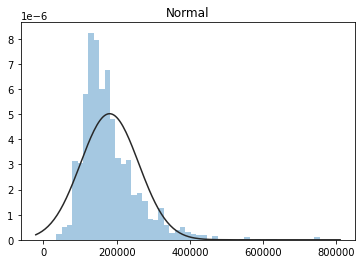

In [ ]:
plt.figure(1); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

Since, the SalePrice is not fitting with the Normal Distribution, next, we try to find the log distribution of the 'SalePrice'. 

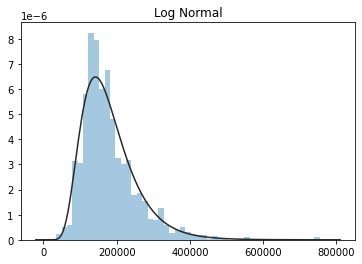

In [ ]:
plt.figure(2); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

And, we can see that the Sales Price is fitting much more for the log normal distribution, keeping that in mind we can safely say for training and testing purpose conversion of SalePrice into log scale will give us better result.

### **Explotary Data Analysis**

**Distribution of continuous variables** 

Next, we want to investigate the distribution of all the continuous independent variables.as this will give us the idea about their nature and importance respective to the 'SalePrice'.

The 'Id' column is nothing but the row number of the dataset therefore it does not have significant role to play, so we remove it from further calclculation.

In [ ]:
data1 = train.drop('Id')

Here, we have created a Python list that contains the name of the columns that are numerical data type.

In [ ]:
quant_col = [x.name for x in data1.schema.fields if isinstance(x.dataType, DoubleType)]

In [ ]:
quant_col

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

Next we have converted to Pandas dataframe for those columns

In [ ]:
# Converting to Pnadas DataFrame
x  = train.select(quant_col).toPandas()

Now, we want to create the distribution graph for each of these numerical columns. Because, it will give us netter understanding about those columns. 

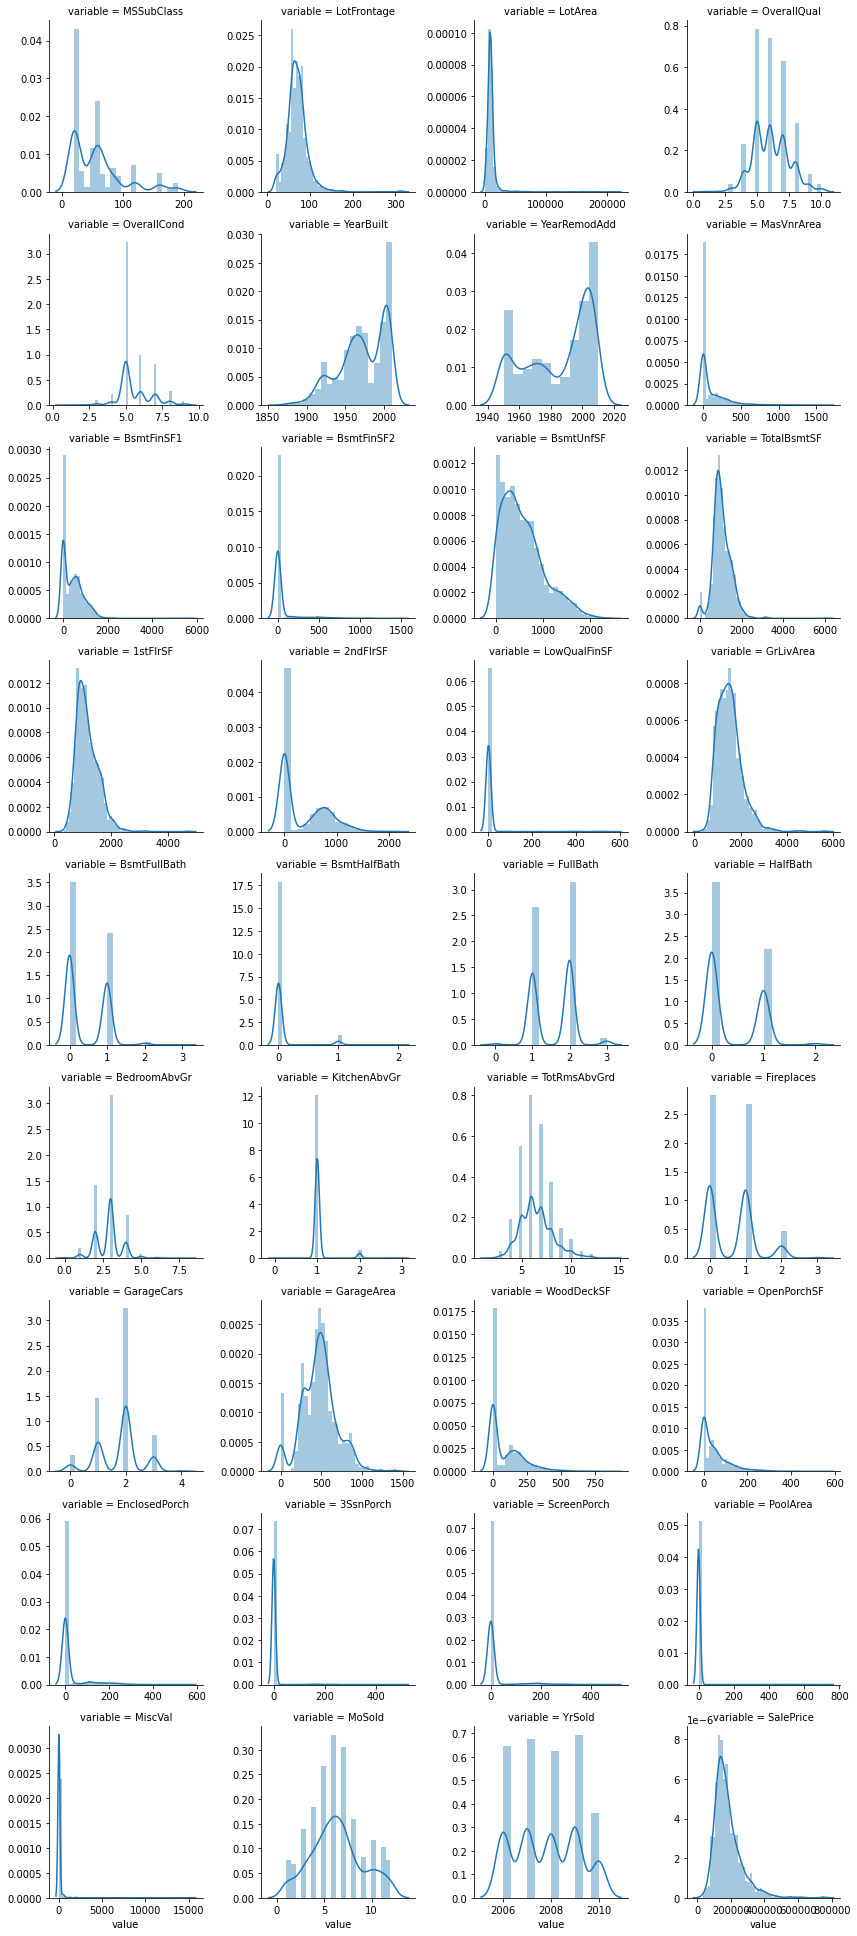

In [ ]:
x = pd.melt(x, value_vars= quant_col)
x1 = sns.FacetGrid(x, col='variable', col_wrap =4 ,sharex= False, sharey = False)
x1 = x1.map(sns.distplot, 'value')

As we can see there are a few of the variables such as 'MoSold', 'YrSold', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath' GarageYearBuilt' and 'Fireplaces' are considered as continuous variable but this graphs shows they are categorical in nature. Whereas, 'GrLiveArea', 'LotArea', 'MSSubClass' and 'LotForntage' are highly skewed data, probably converting them in log scale will increase our model for better prediction. 

**Correlation Matrix for our variables.**

In [ ]:
df = train.toPandas()


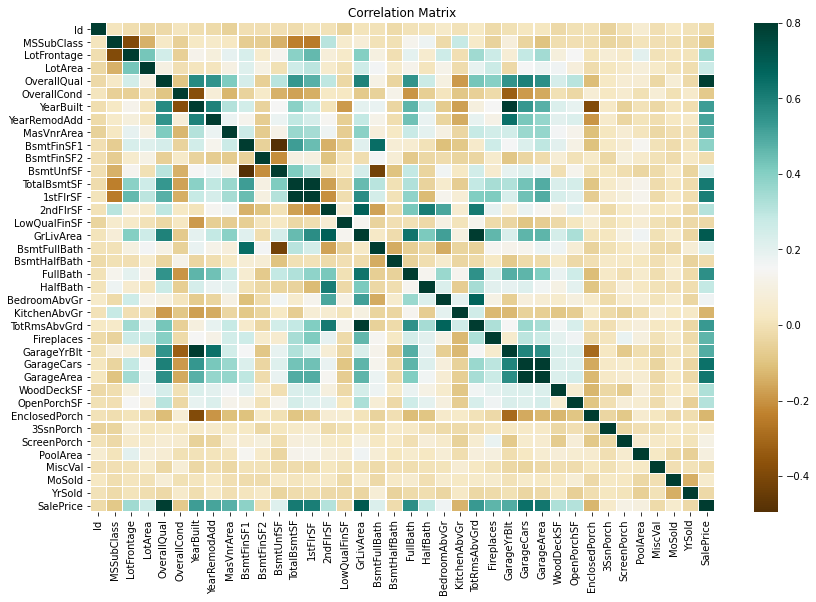

In [ ]:
cm = df.corr()
f, ax = plt.subplots(figsize=(14,9))
plt.title('Correlation Matrix')
sns.heatmap(cm, vmax=0.8, cmap='BrBG', linewidth=0.2 )

_'GarageCars'_ and _'GarageArea'_ are very strongly related, so it can be assumed that there is multicolinearity between them so we will keep _'GarageArea'_ and remove _'GarageCars'_


In [ ]:
numeric_features_df  = train.select(quant_col)

In [ ]:
numeric_features_df.show(5)

+----------+-----------+-------+-----------+-----------+---------+------------+----------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+---------+
|MSSubClass|LotFrontage|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|MasVnrArea|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|BsmtFullBath|BsmtHalfBath|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|SalePrice|
+----------+-----------+-------+-----------+-----------+---------+------------+----------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+------

In [ ]:
import six
for i in train.columns:
    if not( isinstance(train.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Sale Price for ", i, train.stat.corr('SalePrice',i))

Correlation to Sale Price for  Id -0.021916719443430967
Correlation to Sale Price for  MSSubClass -0.08428413512659509
Correlation to Sale Price for  LotFrontage 0.2096239447994837
Correlation to Sale Price for  LotArea 0.2638433538714051
Correlation to Sale Price for  OverallQual 0.7909816005838053
Correlation to Sale Price for  OverallCond -0.07785589404867796
Correlation to Sale Price for  YearBuilt 0.522897332879497
Correlation to Sale Price for  YearRemodAdd 0.5071009671113869
Correlation to Sale Price for  MasVnrArea 0.4726144990045735
Correlation to Sale Price for  BsmtFinSF1 0.38641980624215344
Correlation to Sale Price for  BsmtFinSF2 -0.011378121450215155
Correlation to Sale Price for  BsmtUnfSF 0.21447910554696925
Correlation to Sale Price for  TotalBsmtSF 0.6135805515591942
Correlation to Sale Price for  1stFlrSF 0.6058521846919153
Correlation to Sale Price for  2ndFlrSF 0.3193338028320674
Correlation to Sale Price for  LowQualFinSF -0.02560613000067957
Correlation to Sale 

**Exploring the categorical variables** 

Here, we want to explore the categorical variables but before starting exploring I will replace all the missing values with the term 'Missing' in order to have a better understand of the data.

Next, we care a Python list that contains the name of coulmns that categorical in nature. Then, define a data frame with all the categorical variables

In [ ]:
qual_col = [x.name for x in train.schema.fields if isinstance(x.dataType, StringType)]

In [ ]:
qual_col

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [ ]:
cat  = train.select(qual_col)
cat.show(5)

+--------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+---------+--------+-----------+-----------+----------+---------+---------+----------+--------+--------+------------+------------+------------+-------+---------+----------+----------+-----------+----------+-----------+----------+------------+----------+----------+----------+------+-----+-----------+--------+-------------+
|MSZoning|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|RoofStyle|RoofMatl|Exterior1st|Exterior2nd|MasVnrType|ExterQual|ExterCond|Foundation|BsmtQual|BsmtCond|BsmtExposure|BsmtFinType1|BsmtFinType2|Heating|HeatingQC|CentralAir|Electrical|KitchenQual|Functional|FireplaceQu|GarageType|GarageFinish|GarageQual|GarageCond|PavedDrive|PoolQC|Fence|MiscFeature|SaleType|SaleCondition|
+--------+------+-----+--------+-----------+---------+---------+---------+------------+---------

In the dataframe, all the Null/Nan values are represented as NA, therefore we need to replace those values with 'Missing'.

In [ ]:
cat = cat.replace('NA','Missing')
cat.show(5)

+--------+------+-------+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+---------+--------+-----------+-----------+----------+---------+---------+----------+--------+--------+------------+------------+------------+-------+---------+----------+----------+-----------+----------+-----------+----------+------------+----------+----------+----------+-------+-------+-----------+--------+-------------+
|MSZoning|Street|  Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|RoofStyle|RoofMatl|Exterior1st|Exterior2nd|MasVnrType|ExterQual|ExterCond|Foundation|BsmtQual|BsmtCond|BsmtExposure|BsmtFinType1|BsmtFinType2|Heating|HeatingQC|CentralAir|Electrical|KitchenQual|Functional|FireplaceQu|GarageType|GarageFinish|GarageQual|GarageCond|PavedDrive| PoolQC|  Fence|MiscFeature|SaleType|SaleCondition|
+--------+------+-------+--------+-----------+---------+---------+---------+----------

Since, Sales Price is not a categorical variable, it is not part of this dataframe but we need to this column for our analysis. So, we create another data only ***SalePrice*** column.

In [ ]:
sp = train.select('SalePrice')
sp.show(5)

+---------+
|SalePrice|
+---------+
| 208500.0|
| 181500.0|
| 223500.0|
| 140000.0|
| 250000.0|
+---------+
only showing top 5 rows



Next, we converted both of them to a Pandas dataframe. 

In [ ]:
cat = cat.toPandas()
sp = sp.toPandas()
print(cat.shape, sp.shape)


(1460, 43) (1460, 1)


After that we have concatenate these two dataframe and create a single dataframe.

In [ ]:
cat1= pd.concat([cat, sp], axis=1)

cat1.shape

(1460, 44)

Here, we have a boxplot for each of these categorical variables to their distribution. We have used Seaborn library to create these graphs.

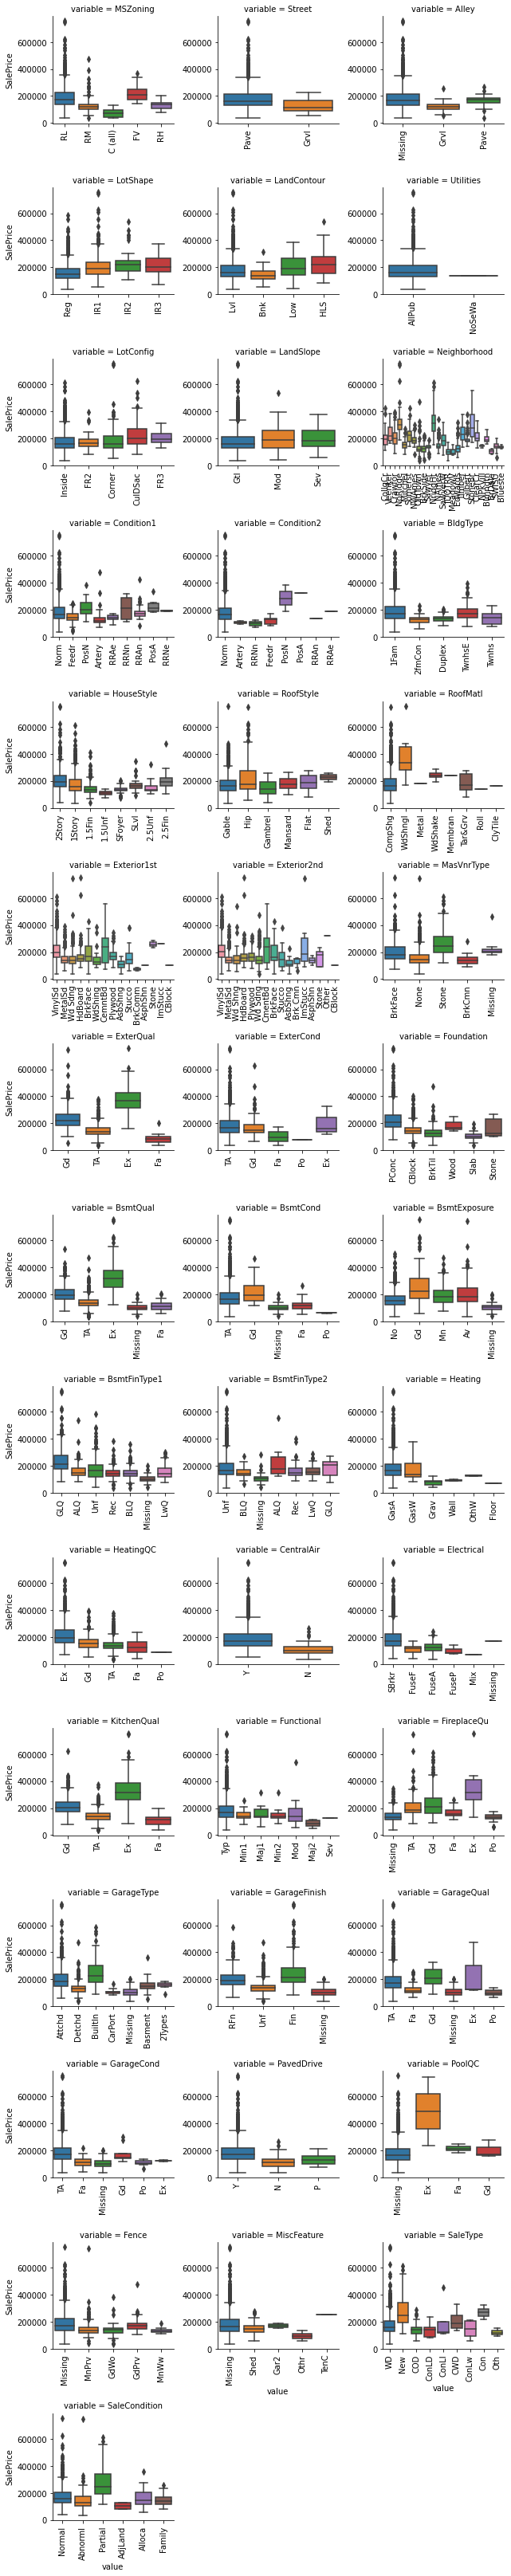

In [ ]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x = plt.xticks(rotation=90)

a = pd.melt(cat1, id_vars =['SalePrice'], value_vars =qual_col )
b = sns.FacetGrid(a, col='variable', col_wrap=3, sharex=False, sharey=False)
b = b.map(boxplot, 'value', 'SalePrice')

## **Implementation**

**Training DataSet**

As we know, the training data set 1460 rows and 81 columns. 

In [ ]:
# Reading the Training data
url = "https://raw.githubusercontent.com/tuhin-datascience2/housingprice/main/train.csv"

spark.sparkContext.addFile(url)

train = spark.read.csv(SparkFiles.get("train.csv"), sep=',', header=True)

In [ ]:
print("The dataset contains a total of {} rows and {} columns".format(train.count(), len(train.columns))) 


The dataset contains a total of 1460 rows and 81 columns


In [ ]:
train.printSchema()

root
 |-- Id: string (nullable = true)
 |-- MSSubClass: string (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: string (nullable = true)
 |-- OverallCond: string (nullable = true)
 |-- YearBuilt: string (nullable = true)
 |-- YearRemodAdd: string (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-- Exteri

Now, we know BsmtFullBath, BsmtHalfBath, HalBath, GarageYearBuilt, YearRemodAdd, YearBuilt, Fireplaces, GarageCars, YearSold, MoSold are not continous variables but they are categorical variables. So, here, we converting those columns that are turly numerical in nature.

In [ ]:
# Converting the string variales to numerical variables. 

train = train.withColumn("Id",train.Id.cast('double')) \
    .withColumn("MSSubClass", train.MSSubClass.cast('double')) \
    .withColumn("LotFrontage", train.LotFrontage.cast('double')) \
    .withColumn("LotArea", train.LotArea.cast('double')) \
    .withColumn("OverallQual", train.OverallQual.cast('double')) \
    .withColumn("OverallCond", train.OverallCond.cast('double')) \
    .withColumn("MasVnrArea", train.MasVnrArea.cast('double')) \
    .withColumn("BsmtFinSF1", train.BsmtFinSF1.cast('double')) \
    .withColumn("BsmtFinSF2", train.BsmtFinSF2.cast('double')) \
    .withColumn("BsmtUnfSF", train.BsmtUnfSF.cast('double')) \
    .withColumn("TotalBsmtSF", train.TotalBsmtSF.cast('double')) \
    .withColumn("1stFlrSF", train['1stFlrSF'].cast('double')) \
    .withColumn("2ndFlrSF", train['2ndFlrSF'].cast('double')) \
    .withColumn("LowQualFinSF", train.LowQualFinSF.cast('double')) \
    .withColumn("GrLivArea", train.GrLivArea.cast('double')) \
    .withColumn("BsmtFullBath", train.BsmtFullBath.cast('double')) \
    .withColumn("BsmtHalfBath", train.BsmtHalfBath.cast('double')) \
    .withColumn("BedroomAbvGr", train.BedroomAbvGr.cast('double')) \
    .withColumn("KitchenAbvGr", train.KitchenAbvGr.cast('double')) \
    .withColumn("TotRmsAbvGrd", train.TotRmsAbvGrd.cast('double')) \
    .withColumn("GarageArea", train.GarageArea.cast('double')) \
    .withColumn("WoodDeckSF", train.WoodDeckSF.cast('double')) \
    .withColumn("OpenPorchSF", train.OpenPorchSF.cast('double')) \
    .withColumn("EnclosedPorch", train.EnclosedPorch.cast('double')) \
    .withColumn("3SsnPorch", train['3SsnPorch'].cast('double')) \
    .withColumn("ScreenPorch", train.ScreenPorch.cast('double')) \
    .withColumn("PoolArea", train.PoolArea.cast('double')) \
    .withColumn("MiscVal", train.MiscVal.cast('double')) \
    .withColumn("SalePrice", train.SalePrice.cast('double')) 

**Adding a new feature**

We have added a new feature called 'TotalSF' which is basically sum of 'TotalBsmtSF', '1srFlrSF' and '2ndFlrSF'

In [ ]:
train = train.withColumn('TotalSF', train['TotalBsmtSF'] + train['1stFlrSF'] +train['2ndFlrSF'] )

And, TotalBsmtFinSF is sum of BsmtFinSF1 and BsmtFinSF2

In [ ]:
train = train.withColumn('TotalBsmtFinSF', train['BsmtFinSF1'] + train['BsmtFinSF2'] )

In [ ]:
train.select('TotalSF').describe().show()

+-------+------------------+
|summary|           TotalSF|
+-------+------------------+
|  count|              1460|
|   mean|2567.0486301369865|
| stddev| 821.7144206684685|
|    min|             334.0|
|    max|           11752.0|
+-------+------------------+



In [ ]:
train.select('TotalBsmtFinSF').describe().show()

+-------+-----------------+
|summary|   TotalBsmtFinSF|
+-------+-----------------+
|  count|             1460|
|   mean|490.1890410958904|
| stddev|476.1033070982844|
|    min|              0.0|
|    max|           5644.0|
+-------+-----------------+



**Reducing features**

'MasVnrType' and 'MasVnrArea' are two non-essential variables also they are strongly related to 'YearBuilt' and 'OverallQual' so we can remove them and as we have discussed before because of multicollinearity we can also remove 'GarageCars'


In [ ]:
train = train.drop('MasVnrType', 'MasVnrArea', 'GarageCars',  '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2')

In [ ]:
train.count(), len(train.columns)

(1460, 75)

Now we are converting all the 'NA' values with 'Missing' for all the categorical/string type variables.

In [ ]:
train = train.replace('NA','Missing')
train.show(10)

+----+----------+--------+-----------+-------+------+-------+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+---------+---------+----------+--------+--------+------------+------------+------------+---------+-------+---------+----------+----------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+-------+-----------+-------+------+------+--------+-------------+---------+-------+--------------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|  Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|OverallQual|OverallCond|YearBui

#### **Creating one Hot Encoders for the categorical variables.**

We do not need the 'Id' column as this is not a feature

In [ ]:
train = train.drop('Id')

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Finding all the categorical variables
qual_col = [x.name for x in train.schema.fields if isinstance(x.dataType, StringType)]

stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in qual_col]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in qual_col]

ppl = Pipeline(stages= stage_string + stage_one_hot)
train = ppl.fit(train).transform(train)

In [ ]:
import pyspark.sql.functions as f 
counts_summary = train.agg(*[f.countDistinct(c).alias(c) for (c,c_type) in train.dtypes if c_type not in ('double')])

counts_summary = counts_summary.toPandas()


counts = pd.Series(counts_summary.values.ravel())
counts.index = counts_summary.columns

sorted_vars = counts.sort_values(ascending = False)
ignore = list((sorted_vars[sorted_vars >100]).index)

Defining the numerical variables which will be Imputed.

In [ ]:
quant_col = [x.name for x in train.schema.fields if isinstance(x.dataType, DoubleType)]
quant_col = [var for var in quant_col if var not in ignore]
numericals_imputed = [var + "_imputed" for var in quant_col]

**Imputing the numerical variables**

The Imputer estimator completes missing values in a dataset, either using the mean or the median of the columns in which the missing values are located, all null values in the input columns are treated as missing, and so are also imputed.

In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols = quant_col, outputCols = numericals_imputed)
train = imputer.fit(train).transform(train)

In [ ]:
train.show(5)

+----------+--------+-----------+-------+------+-------+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+---------+---------+----------+--------+--------+------------+------------+------------+---------+-------+---------+----------+----------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+-------+-----------+-------+------+------+--------+-------------+---------+-------+--------------+-----------------------+---------------------+--------------------+-----------------------+--------------------------+------------------------+------------------------+------------------------+-----------

***One hot encoding for the categorical variables.***

In [ ]:
from pyspark.ml.feature import VectorAssembler

features = numericals_imputed + [var + "_one_hot" for var in qual_col]

vector_assembler = VectorAssembler(inputCols = features, outputCol= "features")
train = vector_assembler.transform(train)

In [ ]:
train.show(10)

+----------+--------+-----------+-------+------+-------+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+---------+---------+----------+--------+--------+------------+------------+------------+---------+-------+---------+----------+----------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+-------+-----------+-------+------+------+--------+-------------+---------+-------+--------------+-----------------------+---------------------+--------------------+-----------------------+--------------------------+------------------------+------------------------+------------------------+-----------

Selecting only the Feature Vectors and Target Variable and discard rest of the columns. 

In [ ]:
train = train.select(['features', 'SalePrice'])

In [ ]:
train.show(5)

+--------------------+---------+
|            features|SalePrice|
+--------------------+---------+
|(586,[0,1,2,3,4,5...| 208500.0|
|(586,[0,1,2,3,4,5...| 181500.0|
|(586,[0,1,2,3,4,5...| 223500.0|
|(586,[0,1,2,3,4,5...| 140000.0|
|(586,[0,1,2,3,4,5...| 250000.0|
+--------------------+---------+
only showing top 5 rows



In [ ]:
train.printSchema()

root
 |-- features: vector (nullable = true)
 |-- SalePrice: double (nullable = true)



In [ ]:
train = train.withColumn("SalePrice",train.SalePrice.cast('double'))

Converting the SalePrice column to Log scale as we have seen before log scale gives the normal distribution for the SalePrice.

In [ ]:
train = train.withColumn("SalePrice", f.log1p(f.col("SalePrice")))


Now, we have data ready to apply on the models.

In [ ]:
train.show(5)

+--------------------+------------------+
|            features|         SalePrice|
+--------------------+------------------+
|(586,[0,1,2,3,4,5...| 12.24769911637256|
|(586,[0,1,2,3,4,5...|12.109016442313738|
|(586,[0,1,2,3,4,5...|12.317171167298682|
|(586,[0,1,2,3,4,5...|11.849404844423074|
|(586,[0,1,2,3,4,5...|12.429220196836383|
+--------------------+------------------+
only showing top 5 rows



In [ ]:
train.count()

1460

### **Developing Test Data**

First we slit the data into two folds, X that will be used for training and validation purpose.
And then we will use y to test the model.

In [ ]:
(X, y) = train.randomSplit([0.992, 0.002], 2021)

Here, we split the data into two section, the y (3 records) which which will use for testing never expose for training and X (1457 records) will be further use training validation

In [ ]:
y.show()

+--------------------+------------------+
|            features|         SalePrice|
+--------------------+------------------+
|(586,[0,1,2,3,4,5...|11.870606902224587|
|(586,[0,1,2,3,4,5...|11.849404844423074|
|(586,[0,1,2,3,4,5...|11.356283350762888|
+--------------------+------------------+



In [ ]:
X.count(), y.count()

(1457, 3)

Next, we splitting the data 80% for training and 20% for validation the model

In [ ]:
(train_data, valid_data) = X.randomSplit([0.8, 0.2], 2020)

In [ ]:
train_data.show(5)

+--------------------+------------------+
|            features|         SalePrice|
+--------------------+------------------+
|(586,[0,1,2,3,4,5...|12.367345048436391|
|(586,[0,1,2,3,4,5...|12.190964083849375|
|(586,[0,1,2,3,4,5...|11.682676678340282|
|(586,[0,1,2,3,4,5...|11.344518647594766|
|(586,[0,1,2,3,4,5...|12.097936057925594|
+--------------------+------------------+
only showing top 5 rows



In [ ]:
valid_data.show(5)

+--------------------+------------------+
|            features|         SalePrice|
+--------------------+------------------+
|(586,[0,1,2,3,4,5...|11.542493975902508|
|(586,[0,1,2,3,4,5...|11.900912042974875|
|(586,[0,1,2,3,4,5...|11.652696102959753|
|(586,[0,1,2,3,4,5...|11.552155793461898|
|(586,[0,1,2,3,4,5...|12.206077645517674|
+--------------------+------------------+
only showing top 5 rows



## **Model Building and Evaluation**

***Ordinary Least Square Regression, when $\lambda =0$ i.e. there is no penalty.***

In [ ]:
# Ordinary Least Square Regression 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

olr = LinearRegression(featuresCol="features", labelCol='SalePrice',  maxIter=100,
regParam=0.0, elasticNetParam=0.0, tol=1e-6, fitIntercept=True, standardization=True, solver="auto", aggregationDepth=2 )

olr_model = olr.fit(train_data)
print("Coefficients: " + str(olr_model.coefficients))
print("Intercept: " + str(olr_model.intercept))

Coefficients: [-0.0004992539481942366,0.0003276283560713312,6.531839977101901e-08,0.014821550398576265,0.016356105792006033,-8.43197709253918e-06,0.0003479149405813556,6.64568684813727e-05,0.024303908348583977,0.0216264268623856,0.011158003839965618,0.052112154949371034,-0.007154678001957696,2.6522014972470066e-05,4.4784305749892706e-05,7.314036943336711e-05,0.00010525380917676547,-3.324757300334251e-05,0.0001495291022061917,-0.000380020720064895,-3.566882018895095e-05,3.3181360035895035e-06,2.2128167748747163e-05,-4.355277242182968e-06,-0.11632321095928906,0.030796575757689605,-0.006253099983909151,0.004429686175991638,0.01628996124494074,-0.0790902621881574,-0.0010061565187212745,-0.028036113113298337,-0.0015004523242933936,0.0005060563554350636,-0.001997164553604493,0.018397231490589798,0.008256098532605614,0.0010888651235693222,0.0005879163676560009,0.047094290623254535,-0.006665992995552359,0.005717872181528214,0.0012551049957417086,-0.002770146713727749,-0.015545079658075042,-0.0

Lets test the Ordinary Least Square regression with the test data and find the **Root Mean Square Error**, **R2** and **Mean Absolute Error** for this model. 

In [ ]:
olr_predictions = olr_model.transform(valid_data)
olr_predictions.select("prediction","SalePrice","features")

olr_evaluator = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="rmse")
rmse = olr_evaluator.evaluate(olr_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

olr_evaluator1 = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="r2")
r2 = olr_evaluator1.evaluate(olr_predictions)
print("R2 on test data = %g" % r2)

olr_evaluator2 = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="mae")
mae = olr_evaluator2.evaluate(olr_predictions)
print("Mean Absolute Error on test data = %g" % mae)

print("The completed Result")

Root Mean Squared Error (RMSE) on test data = 0.108112
R2 on test data = 0.9108
Mean Absolute Error on test data = 0.0752909
The completed Result


##### Ridge Regression 
When $\lambda>0$ (i.e. regParam >0) and $\alpha=0$ (i.e. elasticNetParam =0) , then the penalty is an L2 penalty.

In [ ]:
rlr = LinearRegression(featuresCol="features", labelCol="SalePrice", predictionCol="prediction", maxIter=100,
regParam=0.01, elasticNetParam=0.0, tol=1e-6, fitIntercept=True, standardization=True, solver="auto", aggregationDepth=2)

rlr_model = rlr.fit(train_data)

rlr_predictions = rlr_model.transform(valid_data)
rlr_evaluator = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="rmse")

rmse = rlr_evaluator.evaluate(rlr_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rlr_evaluator1 = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="r2")
r2 = rlr_evaluator1.evaluate(rlr_predictions)
print("R2 on test data = %g" % r2)

rlr_evaluator2 = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="mae")
mae = rlr_evaluator2.evaluate(rlr_predictions)
print("Mean Absolute Error on test data = %g" % mae)

print("The completed Result")

Root Mean Squared Error (RMSE) on test data = 0.0991196
R2 on test data = 0.925021
Mean Absolute Error on test data = 0.0689152
The completed Result


#### Lasso Regression
When $\lambda>0$ (i.e. regParam >0) and $\alpha=1$ (i.e. elasticNetParam =1), then the penalty is an L1 penalty.


In [ ]:
llr = LinearRegression(featuresCol="features", labelCol="SalePrice", predictionCol="prediction", maxIter=100,
regParam=0.2, elasticNetParam=1.0, tol=1e-6, fitIntercept=True, standardization=True, solver="auto", aggregationDepth=2)

llr_model = llr.fit(train_data)

llr_predictions = llr_model.transform(valid_data)
llr_evaluator = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="rmse")

rmse = llr_evaluator.evaluate(llr_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

llr_evaluator1 = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="r2")
r2 = llr_evaluator1.evaluate(llr_predictions)
print("R2 on test data = %g" % r2)

llr_evaluator2 = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="mae")
mae = llr_evaluator2.evaluate(llr_predictions)
print("Mean Absolute Error on test data = %g" % mae)

print("The completed Result")

Root Mean Squared Error (RMSE) on test data = 0.215137
R2 on test data = 0.646776
Mean Absolute Error on test data = 0.174662
The completed Result


#### ElasticNet 
When $\lambda>0$ (i.e. regParam >0) and elasticNetParam $\in (0,1)$ (i.e. $\alpha\in (0,1)$) , then the penalty is an L1 + L2 penalty.


In [ ]:
elr = LinearRegression(featuresCol="features", labelCol="SalePrice", predictionCol="prediction", maxIter=100,
regParam=0.5, elasticNetParam=0.5, tol=1e-6, fitIntercept=True, standardization=True, solver="auto", aggregationDepth=2)

elr_model = elr.fit(train_data)

elr_predictions = elr_model.transform(valid_data)
elr_evaluator = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="rmse")

rmse = elr_evaluator.evaluate(elr_predictions)
r2 = elr_evaluator.evaluate(elr_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

elr_evaluator1 = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="r2")
r2 = elr_evaluator1.evaluate(elr_predictions)
print("R2 on test data = %g" % r2)

elr_evaluator2 = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="mae")
mae = elr_evaluator2.evaluate(elr_predictions)
print("Mean Absolute Error on test data = %g" % mae)

print("The completed Result")

Root Mean Squared Error (RMSE) on test data = 0.289587
R2 on test data = 0.360005
Mean Absolute Error on test data = 0.231986
The completed Result


***Decision Tree Regressor:***

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'SalePrice',predictionCol="prediction", impurity='variance')

dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(valid_data)
dt_evaluator = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="rmse")

rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

dt_evaluator1 = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="r2")

r2 = dt_evaluator1.evaluate(dt_predictions)
print("R2 on test data = %g" % r2)

dt_evaluator2 = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="mae")

mae = dt_evaluator2.evaluate(dt_predictions)
print("Mean Absolute Error on test data = %g" % mae)

print("The completed Result")

Root Mean Squared Error (RMSE) on test data = 0.0320249
R2 on test data = 0.992173
Mean Absolute Error on test data = 0.0214017
The completed Result


***XGBoost Regressor:***

In [ ]:

from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol = 'features', labelCol = 'SalePrice', predictionCol="prediction", maxIter=100, maxDepth=5)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(valid_data)

gbt_evaluator = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="rmse",)
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbt_evaluator1 = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator1.evaluate(gbt_predictions)
print("R2 on test data = %g" % r2)

gbt_evaluator2 = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction", metricName="mae")
mae = gbt_evaluator2.evaluate(gbt_predictions)
print("Mean Absolute Error on test data = %g" % mae)

print("The completed Result")

Root Mean Squared Error (RMSE) on test data = 0.0322726
R2 on test data = 0.992052
Mean Absolute Error on test data = 0.0210116
The completed Result


### **Regression Evalution Metrices**

An important step in any machine learning model is to evaluate the accuracy of the model. The Mean Squared Error, Mean absolute error, Root Mean Squared Error, and R-Squared or Coefficient of determination are very common metrices thatare used to evaluate the performance of the model in regression analysis. Here, we have exaplain some of those metrices.


***- ${MSE}$***

The Mean Squared Error is defines as,  
${MSE=\frac{1}{n}\sum\limits _{i=1} ^{n}(y_{i}−\hat{y})^2}$

And this represents the average of the squared difference between actual and the predicted values for a given dataset. It is basically measures the variance of the residual 

***- ${RMSE}$***

The Root Mean squared Error ${RMSE}$ is defined as simply ${RMSE=\sqrt{MSE}}$ and it measures the standard deviation of the residuals.

${RMSE=\sqrt{\frac{1}{n}\sum\limits _{i=1} ^{n}(y_{i}−\hat{y})^2}}$


***- ${R^2}$***
The coefficient of determination or R-squared ${R^2}$ is represents  

${R^{2}=1−\frac{\sum(y_{i} - \hat{y})^2}{\sum(y_{i} - \bar{y})^2} }$ 

where ${\hat{y}}$ is the predicted value and ${\bar{y}}$ is the mean value . 

And it represents the proportion of the variance for the dependent variables that is explained by the linear regression model and its value falls between 0 and 1

Both, MSE and RMSE penalize the large error in prediction. Although, RMSE is more favourable than MSE when to evaluate the performance of a model. As a mattere of fact, for many models, RMSE is the default metric for calculating the Loss Function.

The smaller value of MSE, and RMSE implies higher accuracy of a regression model. whereas, a bigger value of R square is more desirable.

### ***Result***

Comparing all these differnt regression model,we can say XGBoost regressor perform best among others with, Root Mean Squared Error (RMSE) value of 0.0412, R2 value of 0.987 and Mean Absolute Error on test data = 0.0218. 

Therefore, XGBoost Regressor should be our choice of regression algorithm. 

### ***Cross Validation***

Now we are applying 5 cross validation on the dataset in order to find the average perfoprmance score.

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

params = ParamGridBuilder().build()
evaluator = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction",metricName="rmse")
cv = CrossValidator(estimator=gbt, estimatorParamMaps=params, evaluator=evaluator, numFolds=5, seed=10)

cv = cv.fit(train_data)
evaluator.evaluate(cv.transform(valid_data))

0.04137234852736075

The average RMSE score:

In [ ]:
print(cv.avgMetrics[0])

0.06900441631345616


And this shows, the model improve the performance when we applied 5 fold cross validation on our  model. 

### ***Hyper Parameter Tuning***

Here, we like to conduct the hyper parameter tuning in order to achieve the best of the chose model.

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

params = ParamGridBuilder().addGrid(gbt.maxIter, [10, 100]).addGrid(gbt.maxDepth, [5, 10]).build()
evaluator = RegressionEvaluator(labelCol="SalePrice", predictionCol="prediction",metricName="rmse")
cv = CrossValidator(estimator=gbt, estimatorParamMaps=params, evaluator=evaluator, numFolds=5, seed=10)

cv = cv.fit(train_data)
evaluator.evaluate(cv.transform(valid_data))

0.03281211086380148

In [ ]:
print(cv.avgMetrics[0])
print(cv.bestModel.extractParamMap())
print(cv.bestModel.getMaxIter())


0.07374655049172432
{Param(parent='GBTRegressor_332e762b1553', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='GBTRegressor_332e762b1553', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='GBTRegressor_332e762b1553', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to '

### ***Testing the modle with known Data***

Here, we like to test our model with the test data. As the hyper tuning suggest that the Max Iterator should be 10 instead of 100 as used previously etc.

In [ ]:
y.show()

+--------------------+------------------+
|            features|         SalePrice|
+--------------------+------------------+
|(586,[0,1,2,3,4,5...|11.870606902224587|
|(586,[0,1,2,3,4,5...|11.849404844423074|
|(586,[0,1,2,3,4,5...|11.356283350762888|
+--------------------+------------------+



In [ ]:
y_test = y.select('features')

y_test.show()

+--------------------+
|            features|
+--------------------+
|(586,[0,1,2,3,4,5...|
|(586,[0,1,2,3,4,5...|
|(586,[0,1,2,3,4,5...|
+--------------------+



In [ ]:
gbt_tuned = GBTRegressor(featuresCol = 'features', labelCol = 'SalePrice', predictionCol="prediction", maxIter=10, maxDepth=5)
model_tuned = gbt_tuned.fit(train_data)


In [ ]:
#Predicting the based on new data
pred = gbt_model.transform(y_test)

In [ ]:
pred = pred.withColumn("SalePrice_Pred", f.expm1(f.col("prediction")))

In [ ]:
pred.show()

+--------------------+------------------+------------------+
|            features|        prediction|    SalePrice_Pred|
+--------------------+------------------+------------------+
|(586,[0,1,2,3,4,5...|11.858451455109385| 141272.2807800782|
|(586,[0,1,2,3,4,5...|11.935704578939504|152618.71431026055|
|(586,[0,1,2,3,4,5...|11.353735957604771| 85282.47251922778|
+--------------------+------------------+------------------+



In [ ]:
y = y.withColumn("SalePrice", f.expm1(f.col("SalePrice")))

In [ ]:
pred.select('features','SalePrice_Pred' ).show(), y.select('SalePrice').show()

+--------------------+------------------+
|            features|    SalePrice_Pred|
+--------------------+------------------+
|(586,[0,1,2,3,4,5...| 141272.2807800782|
|(586,[0,1,2,3,4,5...|152618.71431026055|
|(586,[0,1,2,3,4,5...| 85282.47251922778|
+--------------------+------------------+

+-----------------+
|        SalePrice|
+-----------------+
|143000.0000000001|
|139999.9999999999|
|85500.00000000006|
+-----------------+



(None, None)

Finally, we can see after the conversion from log scale to actual Sales Price, our ,model perform very close to actual price and we can call it a successful implementation of regression model.

## **Discussion**

Apache Spark framework is known as a very fast, easy-to-use, and general engine for big data processing. It also has built-in modules for streaming, SQL, Machine Learning (ML), and graph processing. This technology is regularly used by data engineers, but in recent past data, scientists are also reaping the benefit from Spark. Since, it polyglot i.e. supported by Java, Scala, Python, and R which makes it easy to learn without learning another new language. We can use it for *Exploratory Data Analysis (EDA), feature extraction, and, of course, Machine Learning*.

For this task, I have used PySpark (Spark based on Python), and using Google Colab makes it much easy no special installation or environment setup is required to start working PySpark.  

Here, I have taken a dataset for House Price prediction from the Kaggle site and the I have done EDA, then built a few Linear Regression Model such as O*rdinary Linear Regression, Ridge, Lasso, and ElasticNet Regression* and also used *Decision Tree* and *XGBoost Regressor* and then evaluate each of these models, in order to compare them, and come to the conclusion that XGBoost Regressor performed reasonably better than other models. 

Next, we have hypertuned the XGBoost model to achieve the best result and finally we gave an entirely new data set to the model and the model predicted the Sales Price which is very close to the exact value.

Last but not least there is huge potential for PySpark, although I have only explored Linear Regression machine learning libraries of PySpark is quite vast and it will be interesting to learn some of them in the future.



